In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, SimpleRNN, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


C:\Users\ashes\.conda\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


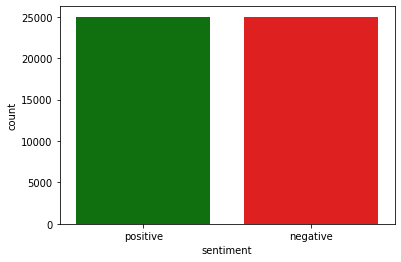

In [3]:
# Check the amount of data each class has
sns.countplot(df["sentiment"], palette = ["green","red"])
plt.show()

In [4]:
# change positive sentiment to 1 and negative to 0
df.sentiment = [ 1 if each == "positive" else 0 for each in df.sentiment]

In [5]:
# data preprocessing
df['review'] = df['review'].apply(lambda x: re.sub('<br />', ' ', x))
df['review'] = df['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

df['review'] = df['review'].apply(lambda x: x.lower())

df['review'] = df['review'].apply(lambda x: x.strip())
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming te...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


In [6]:
# Tokenize
def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in set(stopwords.words("english"))]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

In [7]:
%time df['review'] = df['review'].apply(lambda x: token(x))

Wall time: 43min 7s


In [8]:
sentiment = df['sentiment'].values
sentiment

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [9]:
df = df['review']

In [10]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df, sentiment, test_size = 0.2, random_state = 42)

In [11]:
# Creating a dictionary of 15000 most used words in english
tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(df)

In [12]:
# make the comments of different lengths into the same length for the neural network
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [13]:
num_tokens = [len(tokens) for tokens in X_train_tokens + X_test_tokens]
num_tokens = np.array(num_tokens)

In [14]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

272

In [15]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.94496

In [16]:
#data is adjusted according to the number of tokens specified
X_train_pad = pad_sequences(X_train_tokens, maxlen = max_tokens)
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_tokens)
X_train_pad.shape

(40000, 272)

In [17]:
# Making a simple RNN model
model = Sequential()

embedding_size = 50

model.add(Embedding(input_dim = 15000, output_dim = embedding_size, 
                    input_length = max_tokens, name = 'embedding_layer'))

model.add(SimpleRNN(units = 16, return_sequences = True))
model.add(Dropout(0.3))

model.add(SimpleRNN(units = 8, return_sequences = True))
model.add(Dropout(0.3))

model.add(SimpleRNN(units = 4))
model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 272, 50)           750000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 272, 16)           1072      
_________________________________________________________________
dropout (Dropout)            (None, 272, 16)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 272, 8)            200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 272, 8)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0

In [19]:
%time history = model.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs = 10, batch_size=1000)

Epoch 1/10
40/40 [==============================] - 29s 634ms/step - loss: 0.6863 - accuracy: 0.5623 - val_loss: 0.5959 - val_accuracy: 0.7413
Epoch 2/10
40/40 [==============================] - 26s 644ms/step - loss: 0.5547 - accuracy: 0.7382 - val_loss: 0.4854 - val_accuracy: 0.8181
Epoch 3/10
40/40 [==============================] - 25s 617ms/step - loss: 0.4680 - accuracy: 0.8305 - val_loss: 0.4190 - val_accuracy: 0.8415
Epoch 4/10
40/40 [==============================] - 24s 600ms/step - loss: 0.4052 - accuracy: 0.8698 - val_loss: 0.4044 - val_accuracy: 0.8388
Epoch 5/10
40/40 [==============================] - 25s 628ms/step - loss: 0.3766 - accuracy: 0.8770 - val_loss: 0.4026 - val_accuracy: 0.8385
Epoch 6/10
40/40 [==============================] - 25s 622ms/step - loss: 0.3372 - accuracy: 0.8950 - val_loss: 0.3791 - val_accuracy: 0.8508
Epoch 7/10
40/40 [==============================] - 25s 633ms/step - loss: 0.2915 - accuracy: 0.9182 - val_loss: 0.3777 - val_accuracy: 0.8540

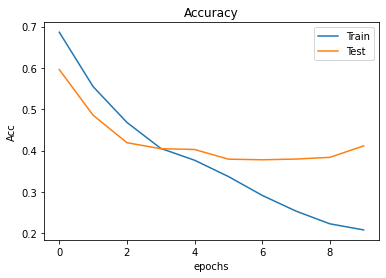

In [20]:
# Plotting the loss for the train and test
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()